In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# FORECASTING CON REDES LSTM - PREDICCIONES DE MERCADO

In [2]:
df = pd.read_csv('../data/indicators_results_10T.csv', sep=';')
df

,datetime,open,close,high,low,up,down,tema_high,tema_low,tema_up,tema_down,macd_line,macd_signal,macd_histogram
0,2022-10-30 21:50:00,4371.25,4374.75,4375.75,4370.75,18.59,10.58,4373.471630,4368.308889,16.383236,13.600468,0.259259,0.051852,0.207407
1,2022-10-30 22:00:00,4374.75,4376.00,4378.00,4373.75,13.48,9.08,4375.168311,4370.332444,15.482362,11.868725,0.559143,0.153310,0.405833
2,2022-10-30 22:10:00,4375.75,4373.50,4377.75,4373.00,7.85,11.63,4376.335240,4371.567881,12.834033,11.482188,0.588293,0.240307,0.347986
3,2022-10-30 22:20:00,4373.50,4373.75,4374.25,4372.25,5.17,6.31,4375.957452,4372.197200,9.921133,9.367452,0.624370,0.317119,0.307250
4,2022-10-30 22:30:00,4373.50,4374.50,4375.50,4372.50,5.97,4.54,4376.076271,4372.714094,8.050711,7.203806,0.705349,0.394765,0.310584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111999,2024-12-16 16:20:00,6151.00,6149.00,6151.25,6148.25,4.32,8.30,6155.259572,6152.949267,7.666592,8.271800,-0.290691,0.356631,-0.647322
112000,2024-12-16 16:30:00,6149.00,6146.75,6149.00,6146.50,3.60,8.10,6153.548034,6151.210011,9.211579,10.860347,-0.422038,0.157756,-0.579794
112001,2024-12-16 16:40:00,6149.25,6149.50,6149.75,6148.00,3.55,4.24,6151.674011,6149.660749,16.387008,18.340250,-0.355168,-0.011202,-0.343966
112002,2024-12-16 16:50:00,6149.25,6149.50,6149.75,6148.00,3.55,4.24,6151.674011,6149.660749,16.387008,18.340250,-0.355168,-0.011202,-0.343966


## Eliminar columna datetime

In [3]:
df = df.drop(columns=['datetime'])
df = df.iloc[1:]
df

,open,close,high,low,up,down,tema_high,tema_low,tema_up,tema_down,macd_line,macd_signal,macd_histogram
1,4374.75,4376.00,4378.00,4373.75,13.48,9.08,4375.168311,4370.332444,15.482362,11.868725,0.559143,0.153310,0.405833
2,4375.75,4373.50,4377.75,4373.00,7.85,11.63,4376.335240,4371.567881,12.834033,11.482188,0.588293,0.240307,0.347986
3,4373.50,4373.75,4374.25,4372.25,5.17,6.31,4375.957452,4372.197200,9.921133,9.367452,0.624370,0.317119,0.307250
4,4373.50,4374.50,4375.50,4372.50,5.97,4.54,4376.076271,4372.714094,8.050711,7.203806,0.705349,0.394765,0.310584
5,4374.25,4377.25,4378.50,4373.75,9.15,7.01,4377.182779,4373.493366,7.814443,6.501051,0.980129,0.511838,0.468291
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111999,6151.00,6149.00,6151.25,6148.25,4.32,8.30,6155.259572,6152.949267,7.666592,8.271800,-0.290691,0.356631,-0.647322
112000,6149.00,6146.75,6149.00,6146.50,3.60,8.10,6153.548034,6151.210011,9.211579,10.860347,-0.422038,0.157756,-0.579794
112001,6149.25,6149.50,6149.75,6148.00,3.55,4.24,6151.674011,6149.660749,16.387008,18.340250,-0.355168,-0.011202,-0.343966
112002,6149.25,6149.50,6149.75,6148.00,3.55,4.24,6151.674011,6149.660749,16.387008,18.340250,-0.355168,-0.011202,-0.343966


In [4]:
# Función para generar las particiones preservando las características
# de la serie de tiempo

def train_val_test_split(dataframe, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = dataframe.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = dataframe[0:Ntrain]
    val = dataframe[Ntrain:Ntrain+Nval]
    test = dataframe[Ntrain+Nval:]

    return train, val, test

# Prueba de la función
tr, vl, ts = train_val_test_split(df)

print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (89602, 13)
Tamaño set de validación: (11200, 13)
Tamaño set de prueba: (11201, 13)


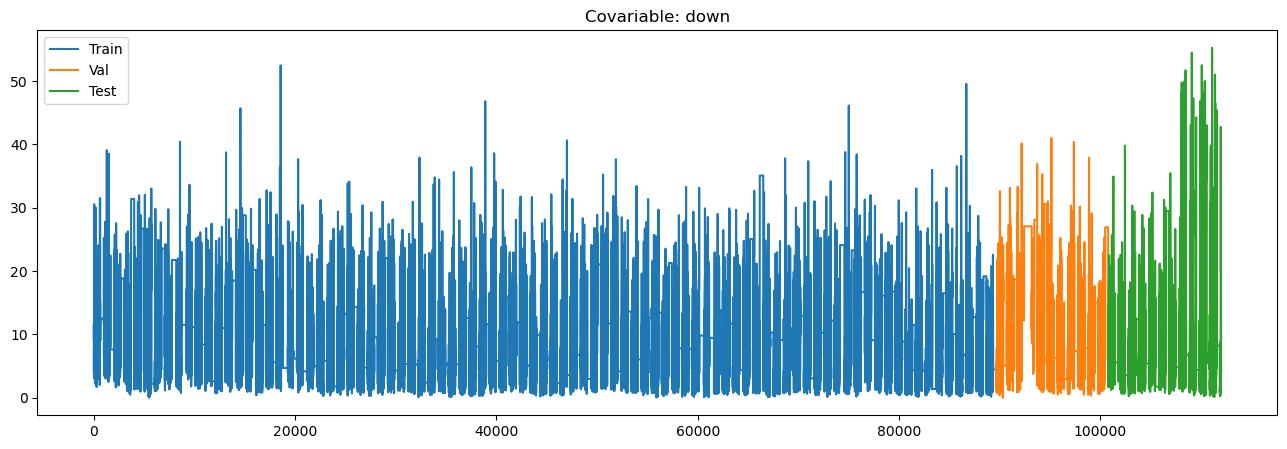

In [5]:
covar = 5 # Índice de la covariable (columna del dataset) a graficar
col = df.columns[covar]

# Dibujar los sets de entrenamiento/validación/prueba para la covariable
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr[col], label='Train')
ax.plot(vl[col], label='Val')
ax.plot(ts[col], label='Test')
ax.set_title(f'Covariable: {col}')
plt.legend();

In [6]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 36    # Hiperparámetro
OUTPUT_LENGTH = 6    # Modelo multi-step

def crear_dataset_supervisado(array, input_length, output_length):
    '''Permite crear un dataset con las entradas (X) y salidas (Y)
    requeridas por la Red LSTM.

    Parámetros:
    - array: arreglo numpy de tamaño N x features (N: cantidad de datos,
      f: cantidad de features)
    - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo
      usados para alimentar el modelo
    - output_length: instantes de tiempo a pronosticar (salida del modelo)
    '''

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado <-- <--- ¡esta parte de la función se ejecuta en este caso!
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+INPUT_LENGTH,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
    
    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

In [7]:


x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (89560, 36, 13), y_tr: (89560, 6, 1)
Set de validación - x_vl: (11158, 36, 13), y_vl: (11158, 6, 1)
Set de prueba - x_ts: (11159, 36, 13), y_ts: (11159, 6, 1)


In [8]:
from sklearn.preprocessing import MinMaxScaler

def escalar_dataset(data_input, col_ref):
    '''Escala el dataset en el rango de -1 a 1.

    Entradas:
    - data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})
    - col_ref: parámetro adicional para especificar la columna que contiene
      la variable a predecir

    
    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

    # *** Implementación adicional: determinar el índice de la columna
    # que contiene la variable a predecir
    col_ref = df.columns.get_loc(col_ref)

    # Número de instantes de tiempo de entrada y de covariables
    NSAMPLES = data_input['x_tr'].shape[1]
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers" (1 por cada covariable de entrada)
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])
    
    # Escalamiento Ys (teniendo en cuenta "col_ind")
    y_tr_s[:,:,0] = scalers[col_ref].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[col_ref].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[col_ref].transform(y_ts[:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[col_ref]

In [9]:
# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar (especificando la columna con la variable a predecir)
data_s, scaler = escalar_dataset(data_in, col_ref = 'close')

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

In [10]:
# Y generemos una gráfica tipo violín para ver la distribución
# de los valores en cada covariable (entrada) y en la variable a
# predecir (salida)

# fig, ax = plt.subplots(figsize=(12,4))
# for i in range(13):
#    ax.violinplot(dataset=x_tr_s[:,:,i].flatten(), positions=[i])
#    ax.violinplot(dataset=x_vl_s[:,:,i].flatten(), positions=[i])
#    ax.violinplot(dataset=x_ts_s[:,:,i].flatten(), positions=[i])

# Etiquetas eje horizontal
# ax.set_xticks(list(range(13)))
# ax.set_xticklabels(df.keys(), rotation=90)
# ax.autoscale()

[Text(1, 0, 'y (salida)')]

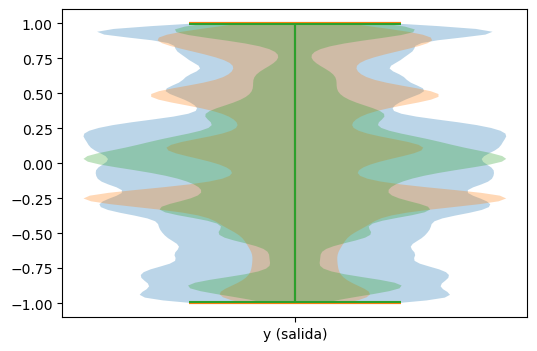

In [11]:
# Y hagamos lo mismo con la variable de salida:
fig, ax = plt.subplots(figsize=(6,4))
ax.violinplot(dataset=y_tr_s.flatten())
ax.violinplot(dataset=y_vl_s.flatten())
ax.violinplot(dataset=y_ts_s.flatten())
ax.set_xticks([1])
ax.set_xticklabels(['y (salida)'])

In [12]:
# Creación del modelo
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Configuración para reproducibilidad
torch.manual_seed(123)
torch.cuda.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(123)

# Definición del modelo LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        lstm_out, _ = self.lstm(x)
        # lstm_out shape: (batch_size, seq_len, hidden_dim)
        
        # Solo necesitamos la última salida para predecir
        last_output = lstm_out[:, -1, :]
        # Capa de salida para la predicción
        output = self.linear(last_output)
        return output

# Hiperparámetros (manteniendo los mismos que en el código original)
N_UNITS = 128  # Tamaño del estado oculto
EPOCHS = 100
BATCH_SIZE = 256
LEARNING_RATE = 0.0001
OUTPUT_LENGTH = 6  # Asumiendo 1 hora de predicción según el código original

# Convertir datos a tensores de PyTorch
# Asumiendo que x_tr_s, y_tr_s, x_vl_s, y_vl_s ya están definidos como arrays numpy
def numpy_to_torch(x, y):
    x_torch = torch.FloatTensor(x)
    y_torch = torch.FloatTensor(y)
    return x_torch, y_torch
 
# Preparar datos para PyTorch (suponiendo que tenemos x_tr_s, y_tr_s, etc.)
x_train_torch, y_train_torch = numpy_to_torch(x_tr_s, y_tr_s)
x_val_torch, y_val_torch = numpy_to_torch(x_vl_s, y_vl_s)

# Crear DataLoaders
train_dataset = TensorDataset(x_train_torch, y_train_torch)
val_dataset = TensorDataset(x_val_torch, y_val_torch)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Inicializar modelo
INPUT_DIM = x_tr_s.shape[2]  # Número de features (13 según el código original)
model = LSTMModel(input_dim=INPUT_DIM, hidden_dim=N_UNITS, output_dim=OUTPUT_LENGTH)

# Función de pérdida personalizada (RMSE)
def root_mean_squared_error(preds, targets):
    return torch.sqrt(torch.mean((preds - targets) ** 2))

# Optimizador (RMSprop para mantener consistencia con el código original)
# optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Scheduler para ajustar la tasa de aprendizaje
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,  # Reduce el learning rate por un factor de 0.1
    patience=5,  # Espera 5 épocas sin mejora antes de reducir el LR
    verbose=True  # Imprime un mensaje cuando el LR cambia
)

# Entrenamiento
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

history = {"train_loss": [], "val_loss": []}

for epoch in range(EPOCHS):
    # Modo entrenamiento
    train_losses = []

    model.train()
    
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        # Forward pass
        predictions = model(batch_x)
        loss = root_mean_squared_error(predictions, 6)
        scheduler.step(loss)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
    
    # Modo evaluación
    model.eval()
    val_losses = []
    
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            predictions = model(batch_x)
            val_loss = root_mean_squared_error(predictions, 6)
            val_losses.append(val_loss.item())
    
    # Almacenar resultados
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    
    # Imprimir progreso (similar al verbose=2 en Keras)
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} - loss: {train_loss:.4f} - val_loss: {val_loss:.4f}")

c:\Users\pc\anaconda3\envs\mp\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100 - loss: 2.5249 - val_loss: 0.0360
Epoch 5/100 - loss: 0.0296 - val_loss: 0.0347
Epoch 10/100 - loss: 0.0284 - val_loss: 0.0331
Epoch 15/100 - loss: 0.0271 - val_loss: 0.0316
Epoch 20/100 - loss: 0.0260 - val_loss: 0.0302
Epoch 25/100 - loss: 0.0249 - val_loss: 0.0289
Epoch 30/100 - loss: 0.0238 - val_loss: 0.0278
Epoch 35/100 - loss: 0.0228 - val_loss: 0.0268
Epoch 40/100 - loss: 0.0218 - val_loss: 0.0259
Epoch 45/100 - loss: 0.0209 - val_loss: 0.0251
Epoch 50/100 - loss: 0.0200 - val_loss: 0.0243
Epoch 55/100 - loss: 0.0192 - val_loss: 0.0239
Epoch 60/100 - loss: 0.0184 - val_loss: 0.0236
Epoch 65/100 - loss: 0.0176 - val_loss: 0.0234
Epoch 70/100 - loss: 0.0168 - val_loss: 0.0233
Epoch 75/100 - loss: 0.0161 - val_loss: 0.0232
Epoch 80/100 - loss: 0.0154 - val_loss: 0.0231
Epoch 85/100 - loss: 0.0148 - val_loss: 0.0231
Epoch 90/100 - loss: 0.0142 - val_loss: 0.0231
Epoch 95/100 - loss: 0.0137 - val_loss: 0.0232
Epoch 100/100 - loss: 0.0132 - val_loss: 0.0233


In [13]:
# Para predecir con el modelo entrenado
def predict(model, x):
    model.eval()
    with torch.no_grad():
        x_torch = torch.FloatTensor(x).to(device)
        predictions = model(x_torch)
        return predictions.cpu().numpy()

In [14]:
x_ts_s

array([[[ 1.05234796e+00,  1.05204003e+00,  1.05140834e+00, ...,
         -4.04457527e-01, -1.91187026e-01, -7.90340223e-01],
        [ 1.05204003e+00,  1.05111624e+00,  1.05171618e+00, ...,
         -4.60686409e-01, -2.56059186e-01, -7.82478691e-01],
        [ 1.05142417e+00,  1.05142417e+00,  1.05048484e+00, ...,
         -4.95632204e-01, -3.15699632e-01, -7.18731612e-01],
        ...,
        [ 1.05573518e+00,  1.05973826e+00,  1.06002771e+00, ...,
         -1.08749543e-01, -3.49687007e-01,  6.90382023e-01],
        [ 1.05973826e+00,  1.05696690e+00,  1.05910420e+00, ...,
         -5.86734836e-02, -2.93787720e-01,  6.89090091e-01],
        [ 1.05665897e+00,  1.05204003e+00,  1.05633369e+00, ...,
         -9.36366592e-02, -2.56814860e-01,  4.58476493e-01]],

       [[ 1.05204003e+00,  1.05111624e+00,  1.05171618e+00, ...,
         -4.60686409e-01, -2.56059186e-01, -7.82478691e-01],
        [ 1.05142417e+00,  1.05142417e+00,  1.05048484e+00, ...,
         -4.95632204e-01, -3.15699632e

In [15]:
y_ts_pred = predict(model, x_ts_s)
y_ts_pred

array([[5.971576 , 5.965483 , 5.963942 , 5.9790077, 5.9613757, 5.9651847],
       [5.9738493, 5.9684014, 5.9662275, 5.9814677, 5.9636135, 5.96839  ],
       [5.974153 , 5.968602 , 5.9665666, 5.981801 , 5.963984 , 5.9686513],
       ...,
       [4.5046086, 4.4121714, 4.419675 , 4.4724817, 4.525146 , 4.480314 ],
       [5.170228 , 5.1156006, 5.116273 , 5.158095 , 5.1846876, 5.1473856],
       [5.5806603, 5.5481215, 5.546144 , 5.574703 , 5.579794 , 5.560782 ]],
      dtype=float32)

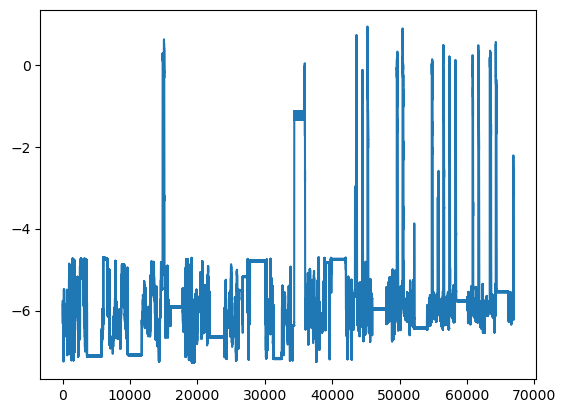

In [16]:
N = len(y_ts_pred)    # Número de predicciones
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred.flatten()
plt.plot(errores)

In [17]:
model.to('cpu')

LSTMModel(
  (lstm): LSTM(13, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=6, bias=True)
)

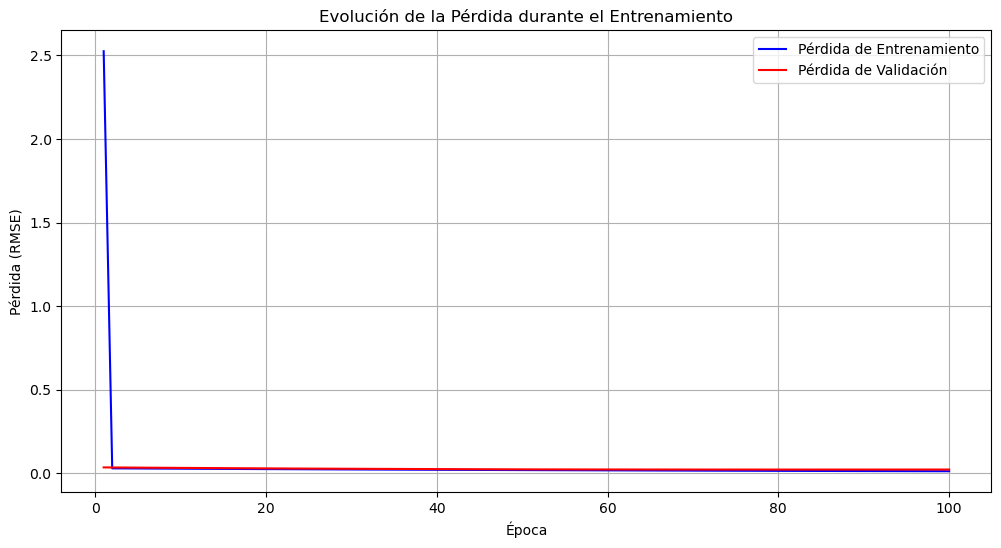

In [18]:
# Visualización de la pérdida
plt.figure(figsize=(12, 6))
plt.plot(range(1, EPOCHS + 1), history['train_loss'], label='Pérdida de Entrenamiento', color='blue')
plt.plot(range(1, EPOCHS + 1), history['val_loss'], label='Pérdida de Validación', color='red')
plt.title('Evolución de la Pérdida durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida (RMSE)')
plt.legend()
plt.grid(True)
plt.show()

# Guardar modelo

In [19]:
model_state_dict = model.state_dict()
optimizer_state_dict = optimizer.state_dict()
torch.save({
    'model_state_dict': model_state_dict,
    'optimizer_state_dict': optimizer_state_dict,
    'epoch': EPOCHS,
    'loss': val_loss,
    'learning_rate': LEARNING_RATE,
    'batch_size': BATCH_SIZE,
    'input_dim': INPUT_DIM,
    'hidden_dim': N_UNITS,
    'output_dim': OUTPUT_LENGTH
}, '../models/adam_lr_0.2_lstm.pth')